In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import glob
import subprocess

In [2]:
with open("EVCS_15_C.gms","r") as f:
    list_of_lines = f.readlines()
    
    
list_of_lines[8]

"power_fee_winter 'fee per max kW per month NOV-MAR NOK/kW' /140/\n"

In [3]:
tariffs = [40,50,60,70,80,90,100,110,120,130,140]

In [4]:
for i in range(len(tariffs)):
    
    with open("EVCS_15_C.gms","r") as f:
        list_of_lines = f.readlines()
    
    list_of_lines[8] = "power_fee_winter 'fee per max kW per month NOV-MAR NOK/kW' /" + str(tariffs[i]) + "/\n"
    
    print(list_of_lines[8])
    
    with open("EVCS_15_C.gms", "w") as f:
        f.writelines(list_of_lines)
        
    subprocess.run(["gams", "EVCS_15_C.gms", "logOption", "2"])
    
    subprocess.run(["move", "EVCS_15_C_results.db", "EVCS_15_C_results" + str(tariffs[i]) + ".db"], shell = True)
    
    print(tariffs[i])

power_fee_winter 'fee per max kW per month NOV-MAR NOK/kW' /40/

40
power_fee_winter 'fee per max kW per month NOV-MAR NOK/kW' /50/

50
power_fee_winter 'fee per max kW per month NOV-MAR NOK/kW' /60/

60
power_fee_winter 'fee per max kW per month NOV-MAR NOK/kW' /70/

70
power_fee_winter 'fee per max kW per month NOV-MAR NOK/kW' /80/

80
power_fee_winter 'fee per max kW per month NOV-MAR NOK/kW' /90/

90
power_fee_winter 'fee per max kW per month NOV-MAR NOK/kW' /100/

100
power_fee_winter 'fee per max kW per month NOV-MAR NOK/kW' /110/

110
power_fee_winter 'fee per max kW per month NOV-MAR NOK/kW' /120/

120
power_fee_winter 'fee per max kW per month NOV-MAR NOK/kW' /130/

130
power_fee_winter 'fee per max kW per month NOV-MAR NOK/kW' /140/

140


In [14]:
#Extract result data from all result databases and create dataframes for each variable

grid_p = pd.DataFrame()
grid_ex_p = pd.DataFrame()
grid_tot_p = pd.DataFrame()

soc_pen = pd.DataFrame()

grid_e = pd.DataFrame()
grid_ex_e = pd.DataFrame()

ESS_lvl = pd.DataFrame()
ESS_p = pd.DataFrame()

sclrs = pd.DataFrame()

for filename in glob.glob('EVCS_15_C_results*.db'):
    con = sqlite3.connect(filename)
    
    grid_power = pd.read_sql_query("SELECT * FROM var_grid_power", con)
    grid_extra_power = pd.read_sql_query("SELECT * FROM var_grid_ex_power", con)
    grid_total_power = pd.read_sql_query("SELECT * FROM var_grid_total_power", con)
    
    grid_energy = pd.read_sql_query("SELECT * FROM var_grid_energy", con)
    grid_extra_energy = pd.read_sql_query("SELECT * FROM var_grid_ex_energy", con)
    
    ESS_level = pd.read_sql_query('SELECT * FROM var_ESS_level', con)
    ESS_power = pd.read_sql_query('SELECT * FROM var_ESS_power', con)
    
    scalars =  pd.read_sql_query('SELECT * FROM scalarvariables', con)
    
    soc_penalty = pd.read_sql_query('SELECT * FROM var_SOC_pen', con)
    
    con.close()
    
    grid_p[filename[17:-3]] = grid_power['level'].copy()
    grid_ex_p[filename[17:-3]] = grid_extra_power['level'].copy()
    grid_tot_p[filename[17:-3]] = grid_total_power['level'].copy()
    
    grid_e[filename[17:-3]] = grid_energy['level'].copy()
    grid_ex_e[filename[17:-3]] = grid_extra_energy['level'].copy() 
    
    ESS_lvl[filename[17:-3]] = ESS_level['level'].copy()
    ESS_p[filename[17:-3]] = ESS_power['level'].copy()  
    
    sclrs[filename[17:-3]] = scalars['level'].copy()
    
    soc_pen[filename[17:-3]] = soc_penalty['level'].copy()



In [15]:
#Scalar variables are collected in one DF. In this cell this df is cleaned and sorted

sclrs = sclrs.set_index(scalars['name'])
sclrs1 = sclrs.T
sclrs1['var_ESS_size'] = sclrs1['var_ESS_size'] * 1.25
sclrs1.index = sclrs1.index.astype(int)
sclrs1 = sclrs1.sort_index(ascending = True)
sclrs1['Power Tariff'] = np.array(tariffs)
sclrs1

name,var_ess_rated_power,var_grid_maxpower1,var_grid_maxpower2,var_grid_maxpower3,var_grid_maxpower4,var_ESS_cost,var_electricity_cost,var_grid_tariff_winter,var_energy_tax,months,var_system_cost,var_ESS_size,Power Tariff
40,89.200000,307.360000,329.040000,263.760000,310.270000,15699.200000,142828.863750,56507.676592,3602.265477,4.283482,221295.277819,89.200000,40
50,140.630682,255.929318,277.609318,212.329318,258.839318,24751.000000,141616.068944,58298.823086,3602.265477,4.283482,231900.285310,140.630682,50
60,171.901639,224.658361,265.601270,181.058361,227.568361,30254.688525,141119.393346,61984.709027,3602.265477,4.283482,241272.321324,171.901639,60
70,173.968750,222.591250,264.807500,180.000000,225.501250,30618.500000,141094.161756,70553.808901,3602.265477,4.283482,250226.077156,173.968750,70
80,216.560000,180.000000,248.452460,166.275833,182.910000,38114.560000,140827.383751,70252.847316,3602.265477,4.283482,258588.139086,216.560000,80
90,219.470000,177.090000,247.385733,163.242041,180.000000,38626.720000,140823.651131,77135.960011,3602.265477,4.283482,266344.519487,219.470000,90
100,220.760000,175.800000,246.913962,159.443333,178.710000,38853.760000,140834.922202,84128.057245,3602.265477,4.283482,273999.466300,220.760000,100
110,232.700000,163.860000,242.547333,154.689388,166.770000,40955.200000,140799.061009,88105.613689,3602.265477,4.283482,281441.057283,232.700000,110
120,241.518125,155.041875,239.322419,152.919677,157.951875,42507.190000,140768.687589,92667.812085,3602.265477,4.283482,288595.523064,241.518125,120
130,245.297895,151.262105,237.940103,149.045686,154.172105,43172.429474,140762.867539,98053.626706,3602.265477,4.283482,295578.146904,245.297895,130


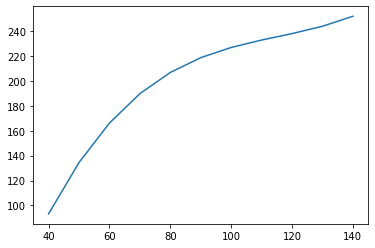

In [24]:
x = sclrs1['Power Tariff']
y = sclrs1['var_ESS_size']

m = np.polyfit(x,y, 3)

m

plt.plot(x, m[0]*x**3+m[1]*x**2 + m[2]*x+m[3])

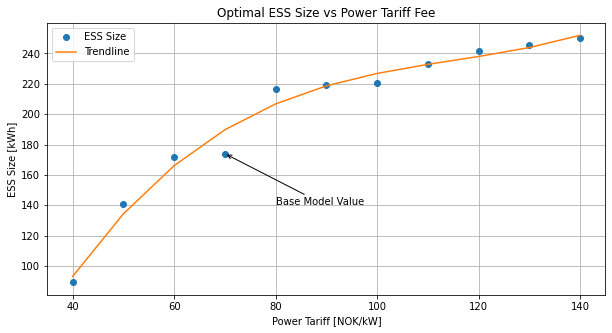

In [30]:
arrowprops = dict(arrowstyle = "->")

x = sclrs1['Power Tariff']
y = sclrs1['var_ESS_size']

m = np.polyfit(x,y, 3)

plt.figure(figsize = (10,5))
plt.plot(x,y,'o', label = 'ESS Size')
plt.plot(x, m[0]*x**3+m[1]*x**2 + m[2]*x+m[3], '-', label = 'Trendline')
plt.annotate('Base Model Value', xy= (x.iloc[3],y.iloc[3]), arrowprops = arrowprops, xytext = (80,140))
plt.xlabel('Power Tariff [NOK/kW]')
plt.ylabel('ESS Size [kWh]')
plt.title('Optimal ESS Size vs Power Tariff Fee')
plt.legend(loc = 'upper left')
plt.grid()

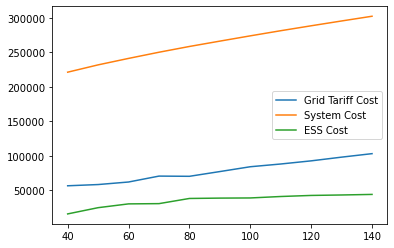

In [11]:
plt.plot(sclrs1['var_grid_tariff_winter'], label = 'Grid Tariff Cost')
plt.plot(sclrs1['var_system_cost'], label = 'System Cost')
plt.plot(sclrs1['var_ESS_cost'], label = 'ESS Cost')
plt.legend()

Text(0, 0.5, '% of system cost')

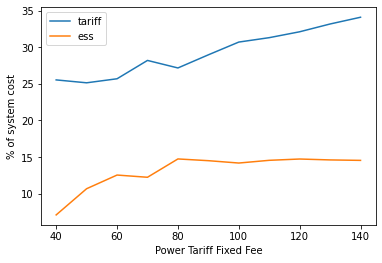

In [18]:
sclrs1['tariff %'] = sclrs1['var_grid_tariff_winter']*100/sclrs1['var_system_cost']
sclrs1['ess %'] = sclrs1['var_ESS_cost']*100/sclrs1['var_system_cost']

plt.plot(sclrs1['tariff %'], label = 'tariff')
plt.plot(sclrs1['ess %'], label = 'ess')
plt.legend()
plt.xlabel('Power Tariff Fixed Fee')
plt.ylabel('% of system cost')

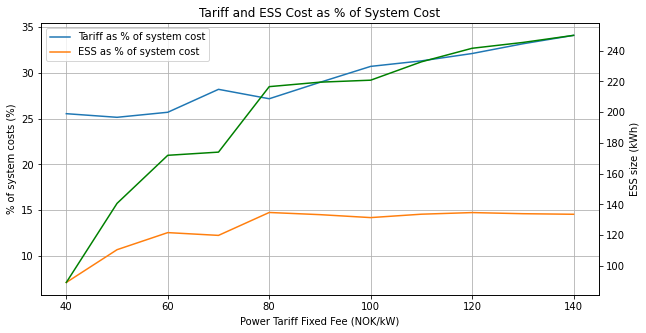

In [20]:
fig, ax1 = plt.subplots(figsize = (10,5))
ax2 = ax1.twinx()

ax1.plot(sclrs1['tariff %'], label = 'Tariff as % of system cost')
ax1.plot(sclrs1['ess %'], label = 'ESS as % of system cost')
ax1.set_ylabel('% of system costs (%)')
ax1.set_xlabel('Power Tariff Fixed Fee (NOK/kW)')
ax1.grid()

ax2.plot(sclrs1['var_ESS_size'], label = 'ESS size', color = 'g')
ax2.set_ylabel('ESS size (kWh)')

ax1.set_title('Tariff and ESS Cost as % of System Cost')
ax1.legend()
#ax2.legend()

It is interesting that the share of battery costs evens out after about 80 NOK/kW while the tariff becomes a larger and larger part of the total costs. Battery size increases throughout the whole range as well. What i want to see as well is this same scenario with the battery size fixed!! So i did it, see scenario C1


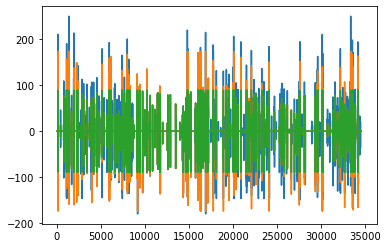

In [15]:
plt.plot(ESS_p['140'])
plt.plot(ESS_p['70'])
plt.plot(ESS_p['40'])

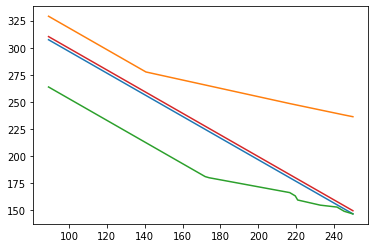

In [7]:
plt.plot(sclrs1['var_grid_maxpower1'])
plt.plot(sclrs1['var_ESS_size'],sclrs1['var_grid_maxpower2'])
plt.plot(sclrs1['var_ESS_size'],sclrs1['var_grid_maxpower3'])
plt.plot(sclrs1['var_ESS_size'],sclrs1['var_grid_maxpower4'])

Text(0.5, 1.0, 'Power Fee = 40')

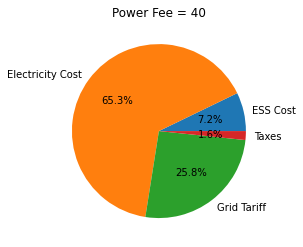

In [44]:
ESS_cost = sclrs1['var_ESS_cost'].iloc[0]
electricity_cost = sclrs1['var_electricity_cost'].iloc[0]
grid_tariff = sclrs1['var_grid_tariff_winter'].iloc[0]
energy_tax = sclrs1['var_energy_tax'].iloc[0]

labels = [ 'ESS Cost', 'Electricity Cost', 'Grid Tariff', 'Taxes']
costs = [ ESS_cost, electricity_cost, grid_tariff, energy_tax]

plt.pie(costs, labels = labels, autopct='%1.1f%%')
plt.grid(axis = 'y')
plt.title('Power Fee = 40')

